# Обучение модели детекции зданий

Детекция объектов для оценки площади зданий с использованием Faster R-CNN с backbone ResNet-50 FPN.

**Датасет**: Inria Aerial Image Labeling Dataset
- Маски сегментации конвертируются в bounding boxes через connected components
- Один класс: Building (здание)

## 1. Импорты и конфигурация

In [1]:
from __future__ import annotations

import json
import logging
import random
import sys
import warnings
from pathlib import Path

# Добавляем корень проекта в путь для импортов
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import torch
import torch.nn as nn
from PIL import Image as PILImage
from torch.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from src.datasets import (
    IMAGENET_MEAN,
    IMAGENET_STD,
    InriaDetectionDataset,
    detection_collate_fn,
    filter_degenerate_boxes,
    get_detection_train_transforms,
    get_detection_val_transforms,
    mask_to_bboxes,
)
from src.models import BuildingDetector
from src.utils import (
    calculate_area_from_boxes,
    calculate_map,
    load_checkpoint,
    save_checkpoint,
    seed_everything,
    visualize_detection,
)

# Подавление конкретных предупреждений от библиотек
warnings.filterwarnings("ignore", category=UserWarning, module="torch")
warnings.filterwarnings("ignore", category=FutureWarning, module="rasterio")

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

/home/user/code/dls_project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ==================== CONFIGURATION ====================

# Paths
DATA_DIR = project_root / "data" / "raw"
CHECKPOINT_DIR = project_root / "checkpoints" / "detection"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

# Training hyperparameters
# RTX 3090 (24 GB VRAM) оптимизации: увеличен batch size и workers
SEED = 42
BATCH_SIZE = 6  # RTX 3090: 24 ГБ VRAM позволяет batch 6 для Faster R-CNN 800x800
NUM_WORKERS = 8  # RTX 3090: больше CPU workers для prefetching
TILE_SIZE = 800
TILES_PER_IMAGE = 5

# Optimizer (SGD рекомендуется для detection)
LEARNING_RATE = 0.005
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

# Training
NUM_EPOCHS = 100
GRADIENT_CLIP = 1.0

# Detection parameters
MIN_BOX_AREA = 100  # Минимальная площадь bbox в пикселях
SCORE_THRESH = 0.5  # Порог для предсказаний

# Dataset parameters
GSD = 0.3  # Ground Sampling Distance (meters/pixel) для Inria dataset

# Device and GPU optimizations for RTX 3090 (Ampere, SM 8.6)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
if torch.cuda.is_available():
    gpu_props = torch.cuda.get_device_properties(0)
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = gpu_props.total_memory / 1e9
    compute_cap_major = gpu_props.major
    compute_cap_minor = gpu_props.minor
    print(f"GPU: {gpu_name}")
    print(f"Memory: {gpu_memory:.1f} GB")
    print(f"Compute capability: {compute_cap_major}.{compute_cap_minor}")
    
    # TensorFloat-32: ускоряет float32 matmul/convolutions на Ampere без потери точности
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    # cuDNN benchmark: находит оптимальные алгоритмы для convolutions
    # Эффективно при фиксированном input size (TILE_SIZE=800)
    torch.backends.cudnn.benchmark = True
    
    # Для Ampere (SM 8.0+) используем bfloat16 вместо float16 — более стабильный
    USE_BFLOAT16 = compute_cap_major >= 8
    AMP_DTYPE = torch.bfloat16 if USE_BFLOAT16 else torch.float16
    
    print("TF32 enabled: matmul + cudnn")
    print("cuDNN benchmark: enabled")
    print(f"AMP dtype: {AMP_DTYPE}")
else:
    USE_BFLOAT16 = False
    AMP_DTYPE = torch.float16

Using device: cuda
GPU: NVIDIA GeForce RTX 3090
Memory: 25.4 GB
Compute capability: 8.6
TF32 enabled: matmul + cudnn
cuDNN benchmark: enabled
AMP dtype: torch.bfloat16


## 2. Установка seed для воспроизводимости

In [3]:
seed_everything(SEED)
print(f"Random seed set to {SEED}")

Random seed set to 42


## 3. Загрузка датасета и создание DataLoader'ов

In [4]:
# Transforms для detection (с поддержкой bbox)
# Dataset уже кропает изображения до TILE_SIZE, transforms только аугментируют и нормализуют
train_transforms = get_detection_train_transforms(min_area=MIN_BOX_AREA)
val_transforms = get_detection_val_transforms(min_area=MIN_BOX_AREA)

# Datasets
train_dataset = InriaDetectionDataset(
    data_dir=DATA_DIR,
    split="train",
    transform=train_transforms,
    tile_size=TILE_SIZE,
    tiles_per_image=TILES_PER_IMAGE,
    min_box_area=MIN_BOX_AREA,
)

val_dataset = InriaDetectionDataset(
    data_dir=DATA_DIR,
    split="val",
    transform=val_transforms,
    tile_size=TILE_SIZE,
    tiles_per_image=TILES_PER_IMAGE,
    min_box_area=MIN_BOX_AREA,
)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")

/home/user/code/dls_project/.venv/lib/python3.12/site-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
2026-01-31 14:36:14,564 - INFO - Found 155 images for detection split 'train'
2026-01-31 14:36:14,568 - INFO - Found 25 images for detection split 'val'


Train dataset: 775 samples
Val dataset: 125 samples


In [5]:
def worker_init_fn(worker_id: int) -> None:
    """Initialize worker with deterministic seed."""
    worker_seed = SEED + worker_id
    random.seed(worker_seed)
    np.random.seed(worker_seed)
    torch.manual_seed(worker_seed)


# Проверка наличия данных перед созданием loaders
if len(train_dataset) == 0:
    raise ValueError("Train dataset is empty! Check DATA_DIR path and data availability.")
if len(val_dataset) == 0:
    raise ValueError("Validation dataset is empty! Check DATA_DIR path and data availability.")

# RTX 3090 DataLoader оптимизации:
# - prefetch_factor=4: больше prefetching для высокопроизводительного GPU
# - multiprocessing_context="spawn": стабильнее на Linux с CUDA
# - persistent_workers: переиспользование workers между эпохами
dataloader_kwargs = {
    "num_workers": NUM_WORKERS,
    "collate_fn": detection_collate_fn,
    "pin_memory": True,
    "worker_init_fn": worker_init_fn,
    "persistent_workers": NUM_WORKERS > 0,
    "prefetch_factor": 4 if NUM_WORKERS > 0 else None,  # RTX 3090: больше prefetch
}

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    **dataloader_kwargs,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    **dataloader_kwargs,
)

print(f"Train batches per epoch: {len(train_loader)}")
print(f"Val batches per epoch: {len(val_loader)}")
print(f"DataLoader: {NUM_WORKERS} workers, prefetch_factor=4")

Train batches per epoch: 129
Val batches per epoch: 21
DataLoader: 8 workers, prefetch_factor=4


## 4. Инициализация модели

In [6]:
model = BuildingDetector(
    pretrained_backbone=True,
    trainable_backbone_layers=3,
    min_size=TILE_SIZE,
    max_size=TILE_SIZE,
    box_score_thresh=0.05,
    box_nms_thresh=0.5,
)
model = model.to(DEVICE)

# Примечание: channels_last НЕ используется для Faster R-CNN, так как модель
# принимает list of (C,H,W) tensors, а не batched (B,C,H,W) tensor.
# channels_last эффективен только для 4D тензоров.

# Подсчёт параметров
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# torch.compile() для ускорения (PyTorch 2.x)
# NOTE: Faster R-CNN имеет проблемы с torch.compile из-за динамических shapes
# (variable number of proposals, boxes, etc.)
USE_TORCH_COMPILE = False  # Отключено для Faster R-CNN

if USE_TORCH_COMPILE and DEVICE.type == "cuda" and hasattr(torch, "compile"):
    print("Compiling model with torch.compile()...")
    try:
        model = torch.compile(model, mode="reduce-overhead")
        print("Model compiled successfully")
    except Exception as e:
        logger.warning(f"torch.compile() failed, continuing without compilation: {e}")
        print(f"[!] torch.compile() failed: {e}")
        print("    Continuing without compilation...")

Total parameters: 41,299,161
Trainable parameters: 41,076,761


## 5. Функция потерь

Faster R-CNN включает loss внутри модели:
- RPN classification loss (objectness)
- RPN box regression loss
- ROI classification loss
- ROI box regression loss

In [7]:
# Faster R-CNN возвращает словарь с losses в training mode
# Дополнительно можно использовать Focal Loss или GIoU через модификацию модели
print("Using built-in Faster R-CNN losses:")
print("  - loss_classifier (Cross Entropy)")
print("  - loss_box_reg (Smooth L1)")
print("  - loss_objectness (RPN)")
print("  - loss_rpn_box_reg (RPN)")

Using built-in Faster R-CNN losses:
  - loss_classifier (Cross Entropy)
  - loss_box_reg (Smooth L1)
  - loss_objectness (RPN)
  - loss_rpn_box_reg (RPN)


## 6. Инициализация оптимизатора и планировщика

In [8]:
# SGD рекомендуется для detection
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
)

# StepLR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.1,
)

# GradScaler для mixed precision (только на GPU)
# RTX 3090: bfloat16 не требует GradScaler (более широкий dynamic range)
USE_AMP = DEVICE.type == "cuda"
if USE_AMP:
    if USE_BFLOAT16:
        # BFloat16 на Ampere: GradScaler не нужен — bf16 имеет такой же exponent как fp32
        scaler = None
        print("BFloat16: GradScaler disabled (not needed for bf16)")
    else:
        try:
            # PyTorch 2.4+: поддерживает device kwarg
            scaler = GradScaler(device="cuda")
        except TypeError:
            # PyTorch < 2.4: без device kwarg
            scaler = GradScaler()
else:
    scaler = None

print(f"Optimizer: SGD (lr={LEARNING_RATE}, momentum={MOMENTUM})")
print("Scheduler: StepLR (step_size=10, gamma=0.1)")
print(f"Mixed Precision: {USE_AMP} (dtype={AMP_DTYPE if USE_AMP else 'N/A'})")

BFloat16: GradScaler disabled (not needed for bf16)
Optimizer: SGD (lr=0.005, momentum=0.9)
Scheduler: StepLR (step_size=10, gamma=0.1)
Mixed Precision: True (dtype=torch.bfloat16)


## 7. Цикл обучения

In [9]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scaler: GradScaler | None,
    device: torch.device,
    epoch: int,
    num_epochs: int,
    use_amp: bool = True,
    amp_dtype: torch.dtype = torch.float16,
    gradient_clip: float = 1.0,
) -> float:
    """
    Train detection model for one epoch.
    
    Args:
        model: Model to train.
        loader: Training data loader.
        optimizer: Optimizer.
        scaler: GradScaler for mixed precision (None if not using AMP or using bfloat16).
        device: Device to train on.
        epoch: Current epoch number.
        num_epochs: Total number of epochs.
        use_amp: Whether to use automatic mixed precision.
        amp_dtype: AMP dtype (torch.float16 or torch.bfloat16).
        gradient_clip: Max gradient norm for clipping.
    
    Returns:
        Average total loss.
    """
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    pbar = tqdm(
        loader,
        desc=f"  Train [{epoch:02d}/{num_epochs:02d}]",
        bar_format="{desc} |{bar:25}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}] {postfix}",
        leave=True,
    )
    
    for batch_idx, (images, targets) in enumerate(pbar):
        # Фильтрация пустых и невалидных targets до переноса на GPU
        # Faster R-CNN требует boxes с положительной шириной и высотой
        valid_indices = []
        filtered_targets = []
        for i, t in enumerate(targets):
            if len(t["boxes"]) == 0:
                continue
            # Фильтрация degenerate boxes (x_max > x_min, y_max > y_min)
            boxes, labels = filter_degenerate_boxes(t["boxes"], t["labels"])
            if len(boxes) > 0:
                filtered_targets.append({"boxes": boxes, "labels": labels})
                valid_indices.append(i)
        
        if len(valid_indices) == 0:
            continue
        
        images = [images[i] for i in valid_indices]
        targets = filtered_targets
        
        # Move to device (non_blocking для асинхронной передачи)
        images = [img.to(device, non_blocking=True) for img in images]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad(set_to_none=True)  # Быстрее чем zero_grad()
        
        # Forward pass (model returns loss dict in training mode)
        with autocast(device_type=device.type, dtype=amp_dtype, enabled=use_amp):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
        
        # Check for NaN/Inf (skip batch before backward)
        if torch.isnan(losses) or torch.isinf(losses):
            tqdm.write(f"  [!] NaN/Inf loss at batch {batch_idx}, skipping...")
            continue
        
        # Backward: GradScaler нужен только для float16, не для bfloat16
        if use_amp and scaler is not None:
            scaler.scale(losses).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            optimizer.step()
        
        total_loss += losses.item()
        num_batches += 1
        
        # Update progress bar
        loss_cls = loss_dict.get("loss_classifier")
        loss_box = loss_dict.get("loss_box_reg")
        cls_str = f"{loss_cls.item():.3f}" if loss_cls is not None else "N/A"
        box_str = f"{loss_box.item():.3f}" if loss_box is not None else "N/A"
        pbar.set_postfix_str(f"loss={losses.item():.4f} | cls={cls_str} | box={box_str}")
    
    return total_loss / max(num_batches, 1)

## 8. Цикл валидации

In [10]:
@torch.inference_mode()
def validate(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    score_thresh: float = 0.5,
) -> float:
    """
    Validate detection model and compute mAP.
    
    Args:
        model: Model to validate.
        loader: Validation data loader.
        device: Device for inference.
        score_thresh: Score threshold for predictions.
    
    Returns:
        mAP@0.5 score.
    """
    model.eval()
    
    all_pred_boxes = []
    all_pred_scores = []
    all_gt_boxes = []
    
    for images, targets in tqdm(loader, desc="  Validating", leave=False):
        # Фильтрация пустых и невалидных targets (аналогично train_one_epoch)
        valid_indices = []
        filtered_targets = []
        for i, t in enumerate(targets):
            if len(t["boxes"]) == 0:
                continue
            # Фильтрация degenerate boxes
            boxes, labels = filter_degenerate_boxes(t["boxes"], t["labels"])
            if len(boxes) > 0:
                filtered_targets.append({"boxes": boxes, "labels": labels})
                valid_indices.append(i)
        
        if len(valid_indices) == 0:
            continue
        
        images = [images[i] for i in valid_indices]
        targets = filtered_targets
        
        # non_blocking для асинхронной передачи
        images = [img.to(device, non_blocking=True) for img in images]
        
        # Inference
        predictions = model(images)
        
        for pred, target in zip(predictions, targets):
            # Filter by score (predictions на GPU, переносим на CPU)
            score_mask = pred["scores"] >= score_thresh
            pred_boxes = pred["boxes"][score_mask].cpu().numpy()
            pred_scores = pred["scores"][score_mask].cpu().numpy()
            # filtered_targets содержит CPU tensors после filter_degenerate_boxes
            gt_boxes = target["boxes"].numpy()
            
            all_pred_boxes.append(pred_boxes)
            all_pred_scores.append(pred_scores)
            all_gt_boxes.append(gt_boxes)
    
    # Calculate mAP@0.5
    map_50 = calculate_map(
        pred_boxes=all_pred_boxes,
        pred_scores=all_pred_scores,
        gt_boxes=all_gt_boxes,
        iou_threshold=0.5,
    )
    
    return map_50

## 9. Обучение

In [11]:
# Training history
history = {
    "train_loss": [],
    "val_map": [],
}

best_map = 0.0
best_epoch = 0

print(f"Starting training for {NUM_EPOCHS} epochs...")
print("-" * 60)

Starting training for 100 epochs...
------------------------------------------------------------


In [12]:
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
    print("-" * 60)
    
    # Train
    train_loss = train_one_epoch(
        model=model,
        loader=train_loader,
        optimizer=optimizer,
        scaler=scaler,
        device=DEVICE,
        epoch=epoch,
        num_epochs=NUM_EPOCHS,
        use_amp=USE_AMP,
        amp_dtype=AMP_DTYPE,
        gradient_clip=GRADIENT_CLIP,
    )
    
    # Scheduler step (per epoch)
    scheduler.step()
    
    # Validate
    val_map = validate(
        model=model,
        loader=val_loader,
        device=DEVICE,
        score_thresh=SCORE_THRESH,
    )
    
    # Save history
    history["train_loss"].append(train_loss)
    history["val_map"].append(val_map)
    
    # Log
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val mAP@0.5: {val_map:.4f}")
    print(f"  LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Save best model
    if val_map > best_map:
        best_map = val_map
        best_epoch = epoch
        
        save_checkpoint(
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            epoch=epoch,
            global_step=epoch * len(train_loader),
            best_metric=best_map,
            path=CHECKPOINT_DIR / "det_best_model.pth",
        )
        print(f"  *** New best model (mAP: {best_map:.4f}) ***")

print("\n" + "=" * 60)
print("Training completed!")
print(f"Best mAP@0.5: {best_map:.4f} at epoch {best_epoch}")


Epoch 1/100
------------------------------------------------------------


  Train [01/100] |█████████████████████████| 129/129 [00:53<00:00,  2.42it/s] , loss=1.0438 | cls=0.163 | box=0.056


  Train Loss: 1.2666
  Val mAP@0.5: 0.0000
  LR: 0.005000

Epoch 2/100
------------------------------------------------------------


  Train [02/100] |█████████████████████████| 129/129 [00:51<00:00,  2.49it/s] , loss=1.6653 | cls=0.439 | box=0.484


  Train Loss: 1.2436
  Val mAP@0.5: 0.0909
  LR: 0.005000


2026-01-31 14:38:26,264 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/detection/det_best_model.pth


  *** New best model (mAP: 0.0909) ***

Epoch 3/100
------------------------------------------------------------


  Train [03/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.1461 | cls=0.324 | box=0.482


  Train Loss: 1.3583
  Val mAP@0.5: 0.1965
  LR: 0.005000


2026-01-31 14:39:30,659 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/detection/det_best_model.pth


  *** New best model (mAP: 0.1965) ***

Epoch 4/100
------------------------------------------------------------


  Train [04/100] |█████████████████████████| 129/129 [00:51<00:00,  2.48it/s] , loss=1.2726 | cls=0.332 | box=0.591


  Train Loss: 1.3794
  Val mAP@0.5: 0.2932
  LR: 0.005000


2026-01-31 14:40:35,884 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/detection/det_best_model.pth


  *** New best model (mAP: 0.2932) ***

Epoch 5/100
------------------------------------------------------------


  Train [05/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.2265 | cls=0.344 | box=0.478


  Train Loss: 1.3124
  Val mAP@0.5: 0.3681
  LR: 0.005000


2026-01-31 14:41:40,286 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/detection/det_best_model.pth


  *** New best model (mAP: 0.3681) ***

Epoch 6/100
------------------------------------------------------------


  Train [06/100] |█████████████████████████| 129/129 [00:51<00:00,  2.50it/s] , loss=1.6563 | cls=0.442 | box=0.694


  Train Loss: 1.3006
  Val mAP@0.5: 0.3837
  LR: 0.005000


2026-01-31 14:42:45,150 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/detection/det_best_model.pth


  *** New best model (mAP: 0.3837) ***

Epoch 7/100
------------------------------------------------------------


  Train [07/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.1421 | cls=0.316 | box=0.506


  Train Loss: 1.2339
  Val mAP@0.5: 0.3916
  LR: 0.005000


2026-01-31 14:43:49,838 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/detection/det_best_model.pth


  *** New best model (mAP: 0.3916) ***

Epoch 8/100
------------------------------------------------------------


  Train [08/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=0.8805 | cls=0.237 | box=0.438


  Train Loss: 1.2192
  Val mAP@0.5: 0.3987
  LR: 0.005000


2026-01-31 14:44:54,247 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/detection/det_best_model.pth


  *** New best model (mAP: 0.3987) ***

Epoch 9/100
------------------------------------------------------------


  Train [09/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.1409 | cls=0.340 | box=0.519


  Train Loss: 1.1939
  Val mAP@0.5: 0.4033
  LR: 0.005000


2026-01-31 14:45:58,941 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/detection/det_best_model.pth


  *** New best model (mAP: 0.4033) ***

Epoch 10/100
------------------------------------------------------------


  Train [10/100] |█████████████████████████| 129/129 [00:51<00:00,  2.50it/s] , loss=1.1152 | cls=0.265 | box=0.453


  Train Loss: 1.1907
  Val mAP@0.5: 0.4593
  LR: 0.000500


2026-01-31 14:47:04,009 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/detection/det_best_model.pth


  *** New best model (mAP: 0.4593) ***

Epoch 11/100
------------------------------------------------------------


  Train [11/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=0.9727 | cls=0.258 | box=0.446


  Train Loss: 1.1033
  Val mAP@0.5: 0.4665
  LR: 0.000500


2026-01-31 14:48:08,677 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/detection/det_best_model.pth


  *** New best model (mAP: 0.4665) ***

Epoch 12/100
------------------------------------------------------------


  Train [12/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=0.9079 | cls=0.246 | box=0.384


  Train Loss: 1.0986
  Val mAP@0.5: 0.4679
  LR: 0.000500


2026-01-31 14:49:13,468 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/detection/det_best_model.pth


  *** New best model (mAP: 0.4679) ***

Epoch 13/100
------------------------------------------------------------


  Train [13/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.3466 | cls=0.317 | box=0.542


  Train Loss: 1.0981
  Val mAP@0.5: 0.4687
  LR: 0.000500


2026-01-31 14:50:18,160 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/detection/det_best_model.pth


  *** New best model (mAP: 0.4687) ***

Epoch 14/100
------------------------------------------------------------


  Train [14/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.1807 | cls=0.273 | box=0.494


  Train Loss: 1.0961
  Val mAP@0.5: 0.4754
  LR: 0.000500


2026-01-31 14:51:22,721 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/detection/det_best_model.pth


  *** New best model (mAP: 0.4754) ***

Epoch 15/100
------------------------------------------------------------


  Train [15/100] |█████████████████████████| 129/129 [00:51<00:00,  2.53it/s] , loss=1.2613 | cls=0.360 | box=0.558


  Train Loss: 1.0713
  Val mAP@0.5: 0.4727
  LR: 0.000500

Epoch 16/100
------------------------------------------------------------


  Train [16/100] |█████████████████████████| 129/129 [00:51<00:00,  2.50it/s] , loss=1.1899 | cls=0.314 | box=0.616


  Train Loss: 1.0775
  Val mAP@0.5: 0.4733
  LR: 0.000500

Epoch 17/100
------------------------------------------------------------


  Train [17/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.0276 | cls=0.285 | box=0.474


  Train Loss: 1.0770
  Val mAP@0.5: 0.4742
  LR: 0.000500

Epoch 18/100
------------------------------------------------------------


  Train [18/100] |█████████████████████████| 129/129 [00:51<00:00,  2.53it/s] , loss=1.1575 | cls=0.299 | box=0.538


  Train Loss: 1.0999
  Val mAP@0.5: 0.4726
  LR: 0.000500

Epoch 19/100
------------------------------------------------------------


  Train [19/100] |█████████████████████████| 129/129 [00:50<00:00,  2.54it/s] , loss=1.3359 | cls=0.352 | box=0.603


  Train Loss: 1.0792
  Val mAP@0.5: 0.4740
  LR: 0.000500

Epoch 20/100
------------------------------------------------------------


  Train [20/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.1748 | cls=0.325 | box=0.527


  Train Loss: 1.0815
  Val mAP@0.5: 0.4715
  LR: 0.000050

Epoch 21/100
------------------------------------------------------------


  Train [21/100] |█████████████████████████| 129/129 [00:51<00:00,  2.50it/s] , loss=1.5019 | cls=0.335 | box=0.530


  Train Loss: 1.1011
  Val mAP@0.5: 0.4736
  LR: 0.000050

Epoch 22/100
------------------------------------------------------------


  Train [22/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.2651 | cls=0.377 | box=0.580


  Train Loss: 1.0717
  Val mAP@0.5: 0.4769
  LR: 0.000050


2026-01-31 14:59:56,226 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/detection/det_best_model.pth


  *** New best model (mAP: 0.4769) ***

Epoch 23/100
------------------------------------------------------------


  Train [23/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=0.8744 | cls=0.217 | box=0.387


  Train Loss: 1.0831
  Val mAP@0.5: 0.4767
  LR: 0.000050

Epoch 24/100
------------------------------------------------------------


  Train [24/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.1896 | cls=0.344 | box=0.527


  Train Loss: 1.0521
  Val mAP@0.5: 0.4752
  LR: 0.000050

Epoch 25/100
------------------------------------------------------------


  Train [25/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=0.9679 | cls=0.254 | box=0.471


  Train Loss: 1.0651
  Val mAP@0.5: 0.4764
  LR: 0.000050

Epoch 26/100
------------------------------------------------------------


  Train [26/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=0.9890 | cls=0.255 | box=0.432


  Train Loss: 1.0798
  Val mAP@0.5: 0.4779
  LR: 0.000050


2026-01-31 15:04:13,099 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/detection/det_best_model.pth


  *** New best model (mAP: 0.4779) ***

Epoch 27/100
------------------------------------------------------------


  Train [27/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=0.9650 | cls=0.262 | box=0.432


  Train Loss: 1.0983
  Val mAP@0.5: 0.4741
  LR: 0.000050

Epoch 28/100
------------------------------------------------------------


  Train [28/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.1638 | cls=0.332 | box=0.574


  Train Loss: 1.0726
  Val mAP@0.5: 0.4759
  LR: 0.000050

Epoch 29/100
------------------------------------------------------------


  Train [29/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.2484 | cls=0.330 | box=0.577


  Train Loss: 1.0565
  Val mAP@0.5: 0.4762
  LR: 0.000050

Epoch 30/100
------------------------------------------------------------


  Train [30/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=0.9120 | cls=0.269 | box=0.479


  Train Loss: 1.0657
  Val mAP@0.5: 0.4758
  LR: 0.000005

Epoch 31/100
------------------------------------------------------------


  Train [31/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.1808 | cls=0.352 | box=0.547


  Train Loss: 1.0606
  Val mAP@0.5: 0.4757
  LR: 0.000005

Epoch 32/100
------------------------------------------------------------


  Train [32/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.5058 | cls=0.387 | box=0.610


  Train Loss: 1.0680
  Val mAP@0.5: 0.4758
  LR: 0.000005

Epoch 33/100
------------------------------------------------------------


  Train [33/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=0.9242 | cls=0.218 | box=0.366


  Train Loss: 1.0667
  Val mAP@0.5: 0.4759
  LR: 0.000005

Epoch 34/100
------------------------------------------------------------


  Train [34/100] |█████████████████████████| 129/129 [00:51<00:00,  2.50it/s] , loss=1.0723 | cls=0.297 | box=0.493


  Train Loss: 1.0801
  Val mAP@0.5: 0.4763
  LR: 0.000005

Epoch 35/100
------------------------------------------------------------


  Train [35/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=0.9845 | cls=0.270 | box=0.423


  Train Loss: 1.0685
  Val mAP@0.5: 0.4755
  LR: 0.000005

Epoch 36/100
------------------------------------------------------------


  Train [36/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=0.8393 | cls=0.244 | box=0.371


  Train Loss: 1.0682
  Val mAP@0.5: 0.4760
  LR: 0.000005

Epoch 37/100
------------------------------------------------------------


  Train [37/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.2350 | cls=0.348 | box=0.551


  Train Loss: 1.0733
  Val mAP@0.5: 0.4760
  LR: 0.000005

Epoch 38/100
------------------------------------------------------------


  Train [38/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.1608 | cls=0.312 | box=0.551


  Train Loss: 1.0778
  Val mAP@0.5: 0.4755
  LR: 0.000005

Epoch 39/100
------------------------------------------------------------


  Train [39/100] |█████████████████████████| 129/129 [00:51<00:00,  2.53it/s] , loss=0.9192 | cls=0.258 | box=0.422


  Train Loss: 1.0713
  Val mAP@0.5: 0.4762
  LR: 0.000005

Epoch 40/100
------------------------------------------------------------


  Train [40/100] |█████████████████████████| 129/129 [00:50<00:00,  2.53it/s] , loss=0.9084 | cls=0.256 | box=0.365


  Train Loss: 1.0805
  Val mAP@0.5: 0.4758
  LR: 0.000001

Epoch 41/100
------------------------------------------------------------


  Train [41/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=0.8190 | cls=0.245 | box=0.408


  Train Loss: 1.0521
  Val mAP@0.5: 0.4760
  LR: 0.000001

Epoch 42/100
------------------------------------------------------------


  Train [42/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.0734 | cls=0.296 | box=0.467


  Train Loss: 1.0528
  Val mAP@0.5: 0.4760
  LR: 0.000001

Epoch 43/100
------------------------------------------------------------


  Train [43/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.2133 | cls=0.333 | box=0.540


  Train Loss: 1.0670
  Val mAP@0.5: 0.4760
  LR: 0.000001

Epoch 44/100
------------------------------------------------------------


  Train [44/100] |█████████████████████████| 129/129 [00:50<00:00,  2.54it/s] , loss=0.9990 | cls=0.225 | box=0.412


  Train Loss: 1.0605
  Val mAP@0.5: 0.4760
  LR: 0.000001

Epoch 45/100
------------------------------------------------------------


  Train [45/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.2228 | cls=0.324 | box=0.554


  Train Loss: 1.0652
  Val mAP@0.5: 0.4758
  LR: 0.000001

Epoch 46/100
------------------------------------------------------------


  Train [46/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.0449 | cls=0.303 | box=0.508


  Train Loss: 1.0746
  Val mAP@0.5: 0.4757
  LR: 0.000001

Epoch 47/100
------------------------------------------------------------


  Train [47/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.1826 | cls=0.364 | box=0.493


  Train Loss: 1.0683
  Val mAP@0.5: 0.4758
  LR: 0.000001

Epoch 48/100
------------------------------------------------------------


  Train [48/100] |█████████████████████████| 129/129 [00:51<00:00,  2.53it/s] , loss=1.1206 | cls=0.305 | box=0.541


  Train Loss: 1.0717
  Val mAP@0.5: 0.4758
  LR: 0.000001

Epoch 49/100
------------------------------------------------------------


  Train [49/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.0608 | cls=0.317 | box=0.456


  Train Loss: 1.0652
  Val mAP@0.5: 0.4760
  LR: 0.000001

Epoch 50/100
------------------------------------------------------------


  Train [50/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=0.7457 | cls=0.204 | box=0.280


  Train Loss: 1.0725
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 51/100
------------------------------------------------------------


  Train [51/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=0.9343 | cls=0.252 | box=0.381


  Train Loss: 1.0713
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 52/100
------------------------------------------------------------


  Train [52/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=0.7381 | cls=0.207 | box=0.366


  Train Loss: 1.0869
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 53/100
------------------------------------------------------------


  Train [53/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=0.9145 | cls=0.252 | box=0.386


  Train Loss: 1.0517
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 54/100
------------------------------------------------------------


  Train [54/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.1765 | cls=0.304 | box=0.534


  Train Loss: 1.0834
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 55/100
------------------------------------------------------------


  Train [55/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.1216 | cls=0.321 | box=0.486


  Train Loss: 1.0701
  Val mAP@0.5: 0.4759
  LR: 0.000000

Epoch 56/100
------------------------------------------------------------


  Train [56/100] |█████████████████████████| 129/129 [00:51<00:00,  2.53it/s] , loss=1.4231 | cls=0.342 | box=0.606


  Train Loss: 1.0881
  Val mAP@0.5: 0.4759
  LR: 0.000000

Epoch 57/100
------------------------------------------------------------


  Train [57/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=0.9053 | cls=0.255 | box=0.402


  Train Loss: 1.0416
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 58/100
------------------------------------------------------------


  Train [58/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=0.9581 | cls=0.258 | box=0.421


  Train Loss: 1.0887
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 59/100
------------------------------------------------------------


  Train [59/100] |█████████████████████████| 129/129 [00:51<00:00,  2.53it/s] , loss=1.0670 | cls=0.269 | box=0.424


  Train Loss: 1.0764
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 60/100
------------------------------------------------------------


  Train [60/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.2034 | cls=0.332 | box=0.537


  Train Loss: 1.0723
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 61/100
------------------------------------------------------------


  Train [61/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.0731 | cls=0.299 | box=0.476


  Train Loss: 1.0752
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 62/100
------------------------------------------------------------


  Train [62/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=0.9986 | cls=0.287 | box=0.431


  Train Loss: 1.0751
  Val mAP@0.5: 0.4759
  LR: 0.000000

Epoch 63/100
------------------------------------------------------------


  Train [63/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=0.8388 | cls=0.261 | box=0.433


  Train Loss: 1.0734
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 64/100
------------------------------------------------------------


  Train [64/100] |█████████████████████████| 129/129 [00:51<00:00,  2.53it/s] , loss=0.8614 | cls=0.262 | box=0.440


  Train Loss: 1.0617
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 65/100
------------------------------------------------------------


  Train [65/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=0.9675 | cls=0.248 | box=0.383


  Train Loss: 1.0603
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 66/100
------------------------------------------------------------


  Train [66/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.0078 | cls=0.254 | box=0.448


  Train Loss: 1.0785
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 67/100
------------------------------------------------------------


  Train [67/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=0.8752 | cls=0.263 | box=0.388


  Train Loss: 1.0645
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 68/100
------------------------------------------------------------


  Train [68/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.1950 | cls=0.299 | box=0.534


  Train Loss: 1.0564
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 69/100
------------------------------------------------------------


  Train [69/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=0.6501 | cls=0.194 | box=0.299


  Train Loss: 1.0722
  Val mAP@0.5: 0.4759
  LR: 0.000000

Epoch 70/100
------------------------------------------------------------


  Train [70/100] |█████████████████████████| 129/129 [00:51<00:00,  2.50it/s] , loss=1.3577 | cls=0.302 | box=0.561


  Train Loss: 1.0578
  Val mAP@0.5: 0.4759
  LR: 0.000000

Epoch 71/100
------------------------------------------------------------


  Train [71/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.1152 | cls=0.315 | box=0.476


  Train Loss: 1.0782
  Val mAP@0.5: 0.4759
  LR: 0.000000

Epoch 72/100
------------------------------------------------------------


  Train [72/100] |█████████████████████████| 129/129 [00:51<00:00,  2.53it/s] , loss=1.1367 | cls=0.326 | box=0.520


  Train Loss: 1.0682
  Val mAP@0.5: 0.4759
  LR: 0.000000

Epoch 73/100
------------------------------------------------------------


  Train [73/100] |█████████████████████████| 129/129 [00:51<00:00,  2.53it/s] , loss=0.9421 | cls=0.261 | box=0.465


  Train Loss: 1.0602
  Val mAP@0.5: 0.4759
  LR: 0.000000

Epoch 74/100
------------------------------------------------------------


  Train [74/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.0438 | cls=0.306 | box=0.480


  Train Loss: 1.0619
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 75/100
------------------------------------------------------------


  Train [75/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.1361 | cls=0.329 | box=0.486


  Train Loss: 1.0672
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 76/100
------------------------------------------------------------


  Train [76/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.1111 | cls=0.285 | box=0.517


  Train Loss: 1.1011
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 77/100
------------------------------------------------------------


  Train [77/100] |█████████████████████████| 129/129 [00:50<00:00,  2.53it/s] , loss=0.7953 | cls=0.207 | box=0.368


  Train Loss: 1.0668
  Val mAP@0.5: 0.4759
  LR: 0.000000

Epoch 78/100
------------------------------------------------------------


  Train [78/100] |█████████████████████████| 129/129 [00:51<00:00,  2.53it/s] , loss=1.2440 | cls=0.337 | box=0.577


  Train Loss: 1.0788
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 79/100
------------------------------------------------------------


  Train [79/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.0738 | cls=0.314 | box=0.484


  Train Loss: 1.0635
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 80/100
------------------------------------------------------------


  Train [80/100] |█████████████████████████| 129/129 [00:51<00:00,  2.53it/s] , loss=1.4456 | cls=0.322 | box=0.605


  Train Loss: 1.0789
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 81/100
------------------------------------------------------------


  Train [81/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.1859 | cls=0.315 | box=0.541


  Train Loss: 1.0649
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 82/100
------------------------------------------------------------


  Train [82/100] |█████████████████████████| 129/129 [00:51<00:00,  2.53it/s] , loss=0.9749 | cls=0.267 | box=0.433


  Train Loss: 1.0650
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 83/100
------------------------------------------------------------


  Train [83/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.0484 | cls=0.282 | box=0.449


  Train Loss: 1.0652
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 84/100
------------------------------------------------------------


  Train [84/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.0842 | cls=0.288 | box=0.467


  Train Loss: 1.0680
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 85/100
------------------------------------------------------------


  Train [85/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.0689 | cls=0.277 | box=0.443


  Train Loss: 1.0654
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 86/100
------------------------------------------------------------


  Train [86/100] |█████████████████████████| 129/129 [00:51<00:00,  2.53it/s] , loss=1.3358 | cls=0.312 | box=0.615


  Train Loss: 1.0465
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 87/100
------------------------------------------------------------


  Train [87/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.1432 | cls=0.288 | box=0.453


  Train Loss: 1.0673
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 88/100
------------------------------------------------------------


  Train [88/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.1673 | cls=0.327 | box=0.485


  Train Loss: 1.0492
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 89/100
------------------------------------------------------------


  Train [89/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.0768 | cls=0.281 | box=0.505


  Train Loss: 1.0738
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 90/100
------------------------------------------------------------


  Train [90/100] |█████████████████████████| 129/129 [00:50<00:00,  2.53it/s] , loss=1.1192 | cls=0.294 | box=0.452


  Train Loss: 1.0669
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 91/100
------------------------------------------------------------


  Train [91/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.2265 | cls=0.321 | box=0.530


  Train Loss: 1.0932
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 92/100
------------------------------------------------------------


  Train [92/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=0.9318 | cls=0.267 | box=0.466


  Train Loss: 1.0712
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 93/100
------------------------------------------------------------


  Train [93/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.0385 | cls=0.314 | box=0.484


  Train Loss: 1.0806
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 94/100
------------------------------------------------------------


  Train [94/100] |█████████████████████████| 129/129 [00:51<00:00,  2.53it/s] , loss=0.9267 | cls=0.285 | box=0.437


  Train Loss: 1.0586
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 95/100
------------------------------------------------------------


  Train [95/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.2690 | cls=0.322 | box=0.596


  Train Loss: 1.0672
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 96/100
------------------------------------------------------------


  Train [96/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=1.1606 | cls=0.308 | box=0.488


  Train Loss: 1.0451
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 97/100
------------------------------------------------------------


  Train [97/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.0766 | cls=0.327 | box=0.456


  Train Loss: 1.0623
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 98/100
------------------------------------------------------------


  Train [98/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.0719 | cls=0.306 | box=0.502


  Train Loss: 1.0677
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 99/100
------------------------------------------------------------


  Train [99/100] |█████████████████████████| 129/129 [00:51<00:00,  2.51it/s] , loss=0.9420 | cls=0.260 | box=0.434


  Train Loss: 1.0800
  Val mAP@0.5: 0.4760
  LR: 0.000000

Epoch 100/100
------------------------------------------------------------


  Train [100/100] |█████████████████████████| 129/129 [00:51<00:00,  2.52it/s] , loss=1.0583 | cls=0.289 | box=0.493


  Train Loss: 1.0420
  Val mAP@0.5: 0.4760
  LR: 0.000000

Training completed!
Best mAP@0.5: 0.4779 at epoch 26


## 10. Сохранение финальной модели

In [13]:
# Сохранение финальной модели
save_checkpoint(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    epoch=NUM_EPOCHS,
    global_step=NUM_EPOCHS * len(train_loader),
    best_metric=best_map,
    path=CHECKPOINT_DIR / "det_final_model.pth",
)
print("Final model saved.")

# Сохранение истории обучения в JSON
history_path = CHECKPOINT_DIR / "det_training_history.json"
with open(history_path, "w") as f:
    json.dump(history, f, indent=2)
print(f"Training history saved to {history_path}")

2026-01-31 16:23:19,923 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/detection/det_final_model.pth


Final model saved.
Training history saved to /home/user/code/dls_project/checkpoints/detection/det_training_history.json


## 11. Визуализация кривых обучения

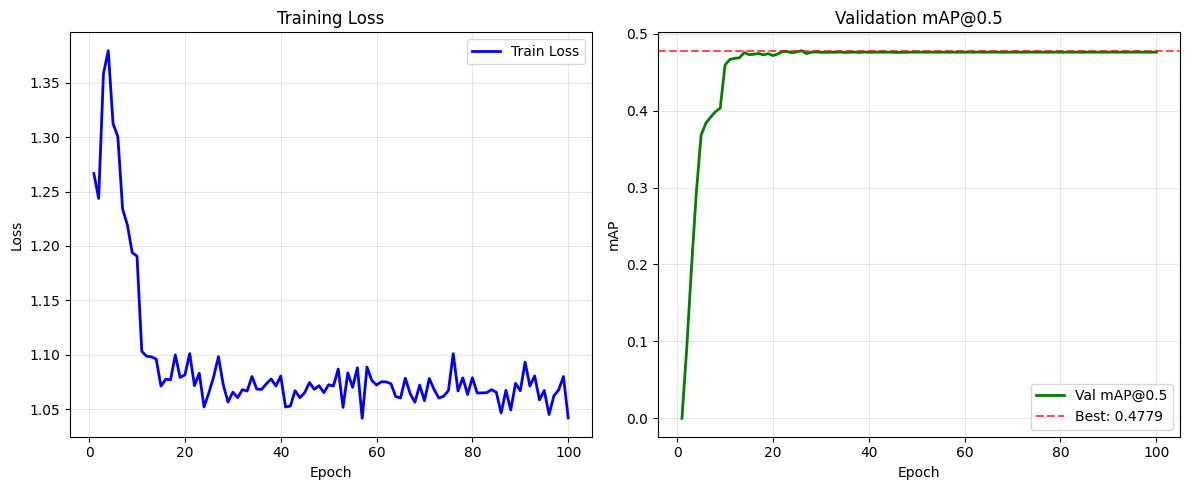

Training curves saved to /home/user/code/dls_project/checkpoints/detection/det_training_curves.png


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss
epochs = range(1, len(history["train_loss"]) + 1)
axes[0].plot(epochs, history["train_loss"], "b-", linewidth=2, label="Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# mAP
axes[1].plot(epochs, history["val_map"], "g-", linewidth=2, label="Val mAP@0.5")
axes[1].axhline(y=best_map, color="r", linestyle="--", alpha=0.7, label=f"Best: {best_map:.4f}")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("mAP")
axes[1].set_title("Validation mAP@0.5")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(CHECKPOINT_DIR / "det_training_curves.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Training curves saved to {CHECKPOINT_DIR / 'det_training_curves.png'}")

## 12. Визуализация предсказаний

In [15]:
# Загрузка лучшей модели
checkpoint_path = CHECKPOINT_DIR / "det_best_model.pth"
if checkpoint_path.exists():
    state = load_checkpoint(checkpoint_path, model, device=DEVICE)
    print(f"Loaded best model from epoch {state['epoch']} with mAP: {state.get('best_metric', 'N/A')}")
else:
    print("Best model checkpoint not found, using current model state.")

2026-01-31 16:23:20,739 - INFO - Model weights loaded from /home/user/code/dls_project/checkpoints/detection/det_best_model.pth


Loaded best model from epoch 26 with mAP: 0.4778676922066208


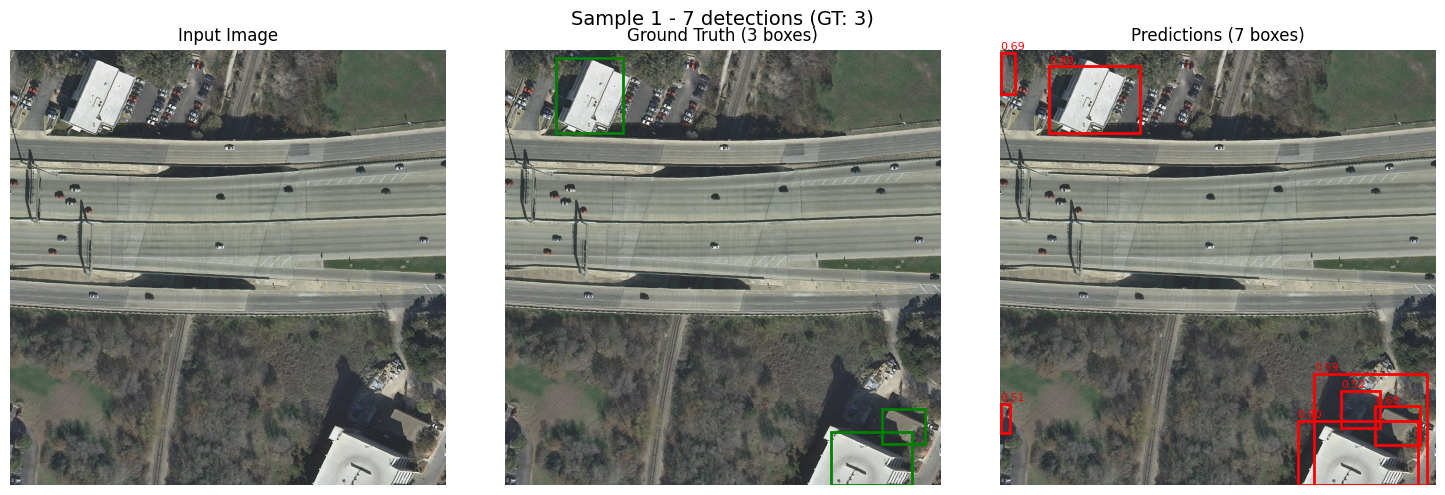

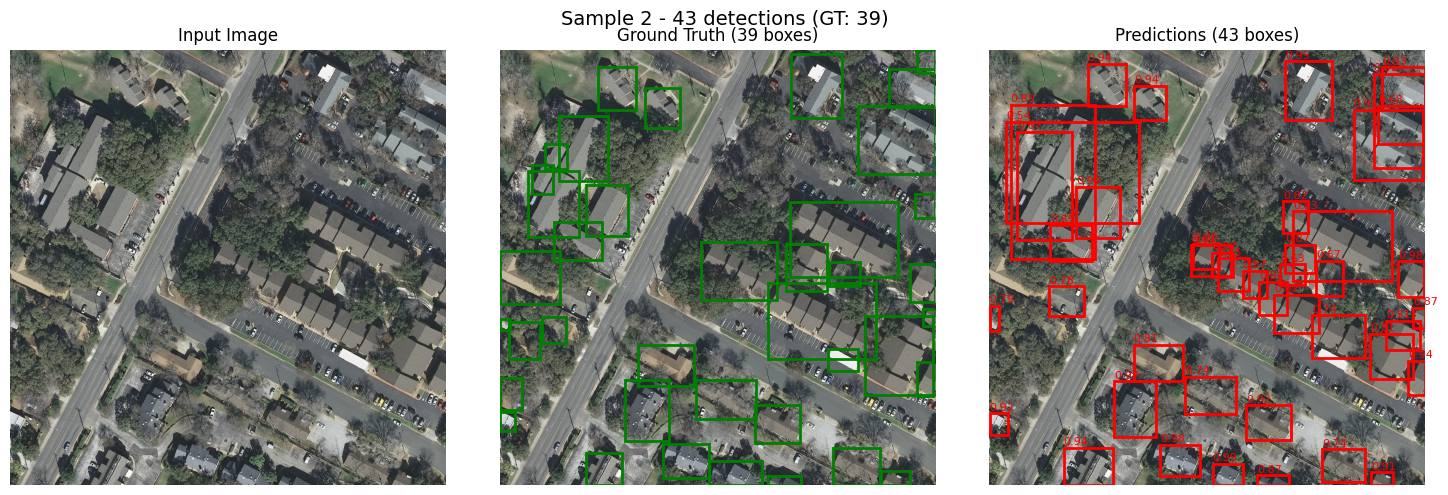

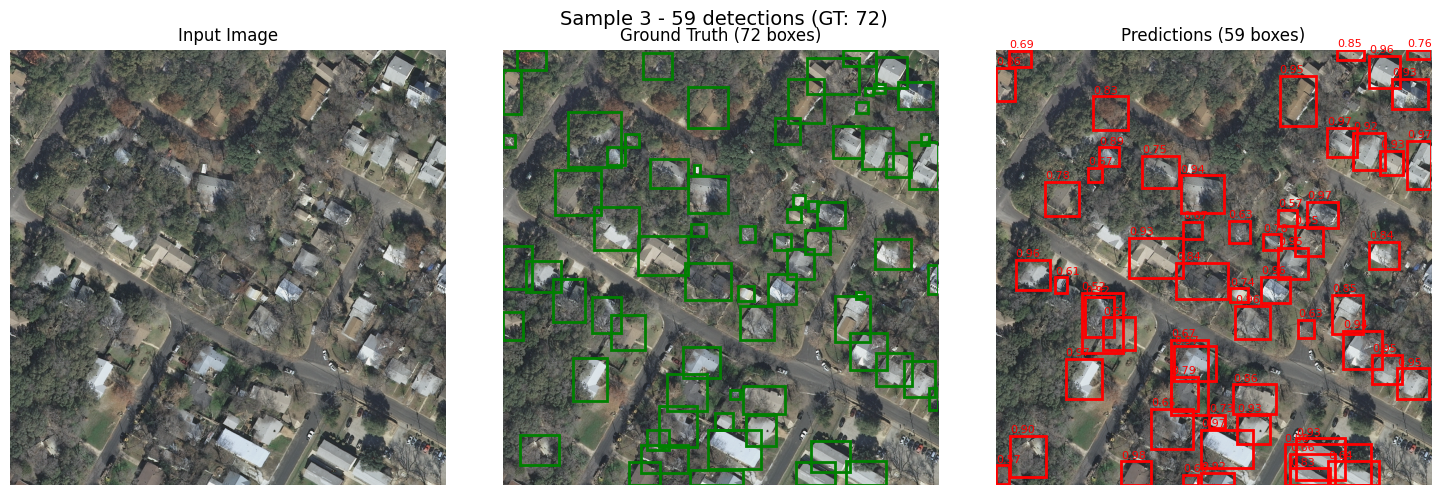

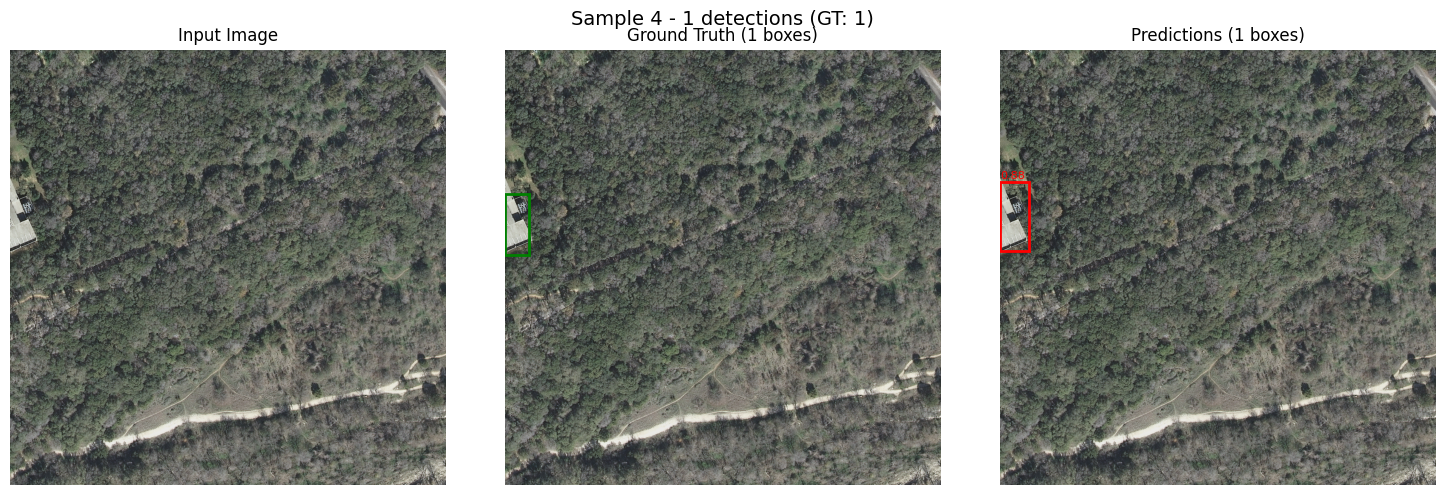

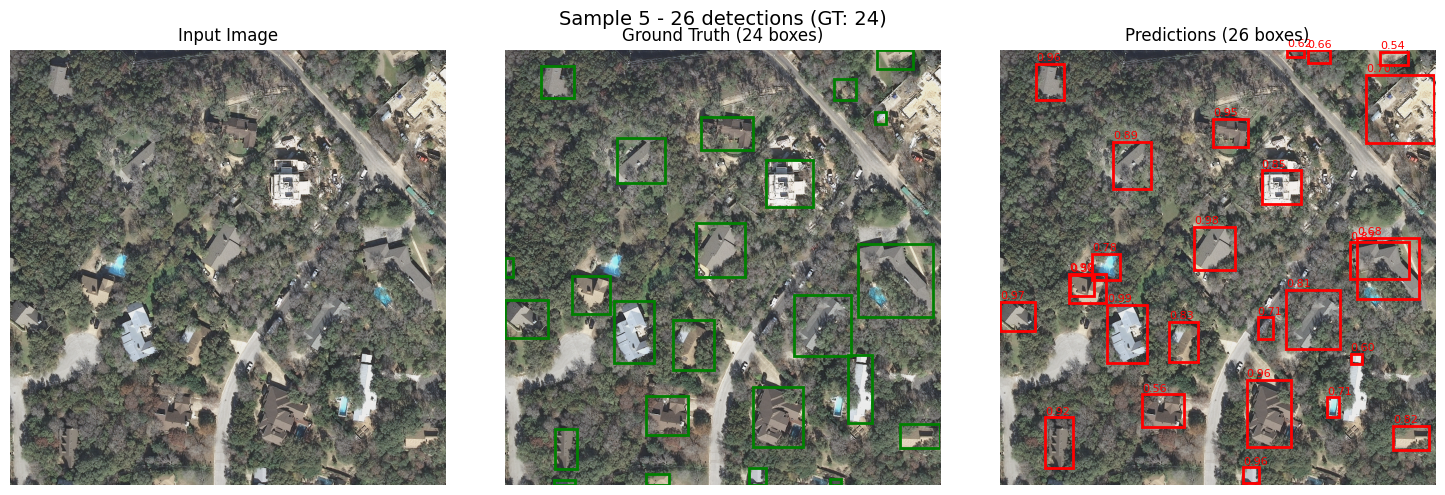

In [16]:
# Визуализация предсказаний
model.eval()
num_samples = 5
samples_shown = 0

# Денормализация для визуализации (reshape для корректного broadcasting с (H, W, C))
mean = np.array(IMAGENET_MEAN, dtype=np.float32).reshape(1, 1, 3)
std = np.array(IMAGENET_STD, dtype=np.float32).reshape(1, 1, 3)

for images, targets in val_loader:
    if samples_shown >= num_samples:
        break
    
    # Пропускаем батчи без валидных targets
    if len(images) == 0 or len(targets) == 0:
        continue
    
    # Находим первое изображение с непустыми и валидными GT boxes
    valid_idx = None
    filtered_gt_boxes = None
    for idx, t in enumerate(targets):
        if len(t["boxes"]) == 0:
            continue
        # Фильтрация degenerate boxes для консистентности с train/validate
        boxes, _ = filter_degenerate_boxes(t["boxes"], t["labels"])
        if len(boxes) > 0:
            valid_idx = idx
            # filter_degenerate_boxes сохраняет тип входа (torch.Tensor), конвертируем в numpy
            filtered_gt_boxes = boxes.numpy()
            break
    
    if valid_idx is None:
        continue
    
    # Отправляем на GPU только выбранное изображение для эффективности
    img_gpu = images[valid_idx].to(DEVICE, non_blocking=True)
    
    with torch.inference_mode():
        predictions = model([img_gpu])
    
    # Визуализация выбранного изображения
    img = images[valid_idx].numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    # Денормализация ImageNet: img = img * std + mean, затем [0, 1] -> [0, 255]
    img = (img * std + mean) * 255.0
    img = np.clip(img, 0, 255).astype(np.uint8)
    
    pred = predictions[0]  # Только одно изображение в batch
    score_mask = pred["scores"] >= SCORE_THRESH
    pred_boxes = pred["boxes"][score_mask].cpu().numpy()
    pred_scores = pred["scores"][score_mask].cpu().numpy()
    
    samples_shown += 1
    visualize_detection(
        image=img,
        boxes_gt=filtered_gt_boxes,
        boxes_pred=pred_boxes,
        scores_pred=pred_scores,
        title=f"Sample {samples_shown} - {len(pred_boxes)} detections (GT: {len(filtered_gt_boxes)})",
    )

## 13. Оценка площади зданий

In [17]:
# Оценка площади для validation set
area_results = []

model.eval()

for images, targets in tqdm(val_loader, desc="Estimating areas"):
    images_gpu = [img.to(DEVICE, non_blocking=True) for img in images]
    
    with torch.inference_mode():
        predictions = model(images_gpu)
    
    # Проверка согласованности: модель должна вернуть prediction для каждого изображения
    if len(predictions) != len(targets):
        logger.warning(
            f"Mismatch: {len(predictions)} predictions vs {len(targets)} targets. Skipping batch."
        )
        continue
    
    for pred, target in zip(predictions, targets):
        # GT area from boxes (фильтрация degenerate для консистентности)
        gt_boxes_raw = target["boxes"]
        gt_boxes_filtered, _ = filter_degenerate_boxes(gt_boxes_raw, None)
        # filter_degenerate_boxes сохраняет тип входа (CPU torch.Tensor), конвертируем в numpy
        if len(gt_boxes_filtered) > 0:
            gt_boxes = gt_boxes_filtered.numpy()
        else:
            gt_boxes = np.zeros((0, 4))
        area_gt = calculate_area_from_boxes(gt_boxes, gsd=GSD)
        
        # Predicted area (predictions на GPU, переносим на CPU)
        score_mask = pred["scores"] >= SCORE_THRESH
        pred_boxes = pred["boxes"][score_mask].cpu().numpy()
        area_pred = calculate_area_from_boxes(pred_boxes, gsd=GSD)
        
        # Корректный расчёт ошибки:
        # - Если GT=0 и Pred=0: ошибка 0% (правильное предсказание)
        # - Если GT=0 и Pred>0: используем NaN (исключаем из MAPE)
        # - Если GT>0: стандартный APE
        if area_gt > 0:
            error_pct = abs(area_pred - area_gt) / area_gt * 100
        elif area_pred == 0:
            error_pct = 0.0  # Оба нулевые — идеальное предсказание
        else:
            error_pct = np.nan  # GT=0, но Pred>0 — исключаем из MAPE
        
        area_results.append({
            "area_gt_m2": area_gt,
            "area_pred_m2": area_pred,
            "error_pct": error_pct,
            "num_gt_boxes": len(gt_boxes),
            "num_pred_boxes": len(pred_boxes),
        })

df_results = pd.DataFrame(area_results)

# Статистика по сэмплам с валидным GT
valid_samples = df_results[df_results["area_gt_m2"] > 0]
empty_gt_samples = df_results[df_results["area_gt_m2"] == 0]

print("\n" + "=" * 60)
print("DETECTION AREA ESTIMATION RESULTS")
print("=" * 60)
print(f"Total samples: {len(df_results)}")
print(f"  - With buildings (GT > 0): {len(valid_samples)}")
print(f"  - Empty tiles (GT = 0): {len(empty_gt_samples)}")
print()
if len(valid_samples) > 0:
    mape = valid_samples["error_pct"].mean()
    median_ape = valid_samples["error_pct"].median()
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Median APE: {median_ape:.2f}%")
else:
    print("No samples with buildings for MAPE calculation.")
print(f"Total GT Area: {df_results['area_gt_m2'].sum():,.0f} m²")
print(f"Total Predicted Area: {df_results['area_pred_m2'].sum():,.0f} m²")
print("\nNote: Bounding box area overestimates actual building footprint.")

df_results.describe()

Estimating areas: 100%|██████████| 21/21 [00:12<00:00,  1.68it/s]


DETECTION AREA ESTIMATION RESULTS
Total samples: 125
  - With buildings (GT > 0): 104
  - Empty tiles (GT = 0): 21

Mean Absolute Percentage Error (MAPE): 82.29%
Median APE: 37.97%
Total GT Area: 1,749,717 m²
Total Predicted Area: 3,287,546 m²

Note: Bounding box area overestimates actual building footprint.


,area_gt_m2,area_pred_m2,error_pct,num_gt_boxes,num_pred_boxes
count,125.000000,125.000000,121.000000,125.00000,125.000000
mean,13997.734316,26300.368496,70.726346,33.41600,29.848000
std,15888.916698,45836.392952,118.604992,43.27075,28.450879
min,0.000000,0.000000,0.000000,0.00000,0.000000
25%,699.659973,781.665588,6.576892,3.00000,4.000000
50%,11012.580078,11685.830078,21.232397,17.00000,26.000000
75%,19036.890625,20412.287109,78.340897,47.00000,48.000000
max,68565.062500,266976.375000,863.895828,205.00000,100.000000


## 14. Сравнение с сегментацией

Оценка площади на основе детекции обычно завышена потому что:
1. Bounding boxes включают фоновые пиксели
2. Площадь box > реальной площади здания

Можно применить корректирующий коэффициент на основе среднего fill ratio.

In [18]:
# Оценка fill ratio из training данных
# Building area / Bounding box area

fill_ratios = []

# Используем samples напрямую (публичный атрибут)
num_samples_to_analyze = min(20, len(train_dataset.samples))
if num_samples_to_analyze == 0:
    print("Warning: No training samples available for fill ratio estimation.")
else:
    for image_path, mask_path in train_dataset.samples[:num_samples_to_analyze]:
        # Загружаем маску через rasterio (локальный импорт для ясности)
        try:
            with rasterio.open(mask_path) as src:
                mask = src.read(1)
        except Exception as e:
            logger.warning(f"Failed to load mask {mask_path} with rasterio: {e}")
            mask = np.array(PILImage.open(mask_path).convert("L"))
        
        boxes = mask_to_bboxes(mask, min_area=MIN_BOX_AREA)
        h, w = mask.shape[:2]
        
        for box in boxes:
            # Clip координаты к границам изображения и конвертация в int
            x1 = int(np.clip(box[0], 0, w))
            y1 = int(np.clip(box[1], 0, h))
            x2 = int(np.clip(box[2], 0, w))
            y2 = int(np.clip(box[3], 0, h))
            
            # Пропуск degenerate boxes после clip
            if y2 <= y1 or x2 <= x1:
                continue
            
            box_mask = mask[y1:y2, x1:x2]
            building_pixels = np.sum(box_mask > 0)
            box_pixels = (y2 - y1) * (x2 - x1)
            if box_pixels > 0:
                fill_ratios.append(building_pixels / box_pixels)

if fill_ratios:
    avg_fill_ratio = np.mean(fill_ratios)
    std_fill_ratio = np.std(fill_ratios)
    print(f"Average fill ratio: {avg_fill_ratio:.3f} ± {std_fill_ratio:.3f}")
    print(f"Boxes analyzed: {len(fill_ratios)}")
    print("\nThis can be used to correct bbox-based area estimates:")
    print(f"Corrected area = bbox_area × {avg_fill_ratio:.3f}")
    
    # Применяем коррекцию к результатам (только для сэмплов с GT > 0)
    df_results["area_pred_corrected_m2"] = df_results["area_pred_m2"] * avg_fill_ratio
    
    # Расчёт скорректированного MAPE только для валидных сэмплов
    valid_gt_mask = df_results["area_gt_m2"] > 0
    if valid_gt_mask.any():
        corrected_errors = (
            abs(df_results.loc[valid_gt_mask, "area_pred_corrected_m2"] - df_results.loc[valid_gt_mask, "area_gt_m2"])
            / df_results.loc[valid_gt_mask, "area_gt_m2"]
            * 100
        )
        corrected_mape = corrected_errors.mean()
        print(f"\nCorrected MAPE: {corrected_mape:.2f}%")
    else:
        print("\nNo samples with GT > 0 for corrected MAPE calculation.")
else:
    print("No boxes found for fill ratio estimation.")

Average fill ratio: 0.583 ± 0.096
Boxes analyzed: 26608

This can be used to correct bbox-based area estimates:
Corrected area = bbox_area × 0.583

Corrected MAPE: 51.27%


## 15. Выводы

### Результаты обучения
- **Best mAP@0.5**: 0.4779 (эпоха 26)
- **Final mAP@0.5**: ~0.476 (стабилизация после 30 эпох)
- **Final Train Loss**: ~1.04
- **Обучение**: 100 эпох, ~51 сек/эпоха на RTX 3090

### Итоги
- **Модель**: Faster R-CNN с backbone ResNet-50 FPN (pretrained на ImageNet)
- **Параметры**: 41.3M total, 41.1M trainable
- **Loss**: Комбинация из 4 компонентов:
  - Cross Entropy для классификации (loss_classifier)
  - Smooth L1 для регрессии bbox (loss_box_reg)
  - Binary Cross Entropy для RPN objectness (loss_objectness)
  - Smooth L1 для RPN box regression (loss_rpn_box_reg)
- **Обучение**: Mixed precision (AMP с BFloat16), оптимизатор SGD с momentum
- **Валидация**: Проводится на отложенной валидационной выборке (5 изображений на город)

### RTX 3090 оптимизации
- **TF32**: Включен для matmul и cuDNN — ускоряет fp32 операции
- **BFloat16 AMP**: Более стабильный чем fp16 на Ampere, GradScaler не нужен
- **Batch Size 6**: Увеличен с 4 благодаря 24 ГБ VRAM
- **8 Workers + prefetch_factor=4**: Агрессивный prefetching для GPU utilization
- **cuDNN Benchmark**: Автоматический выбор оптимальных алгоритмов

> **Примечание**: Channels Last не используется для Faster R-CNN, так как модель принимает list of (C,H,W) tensors, а не batched (B,C,H,W) tensor.

### Динамика обучения
- Быстрый рост mAP в первые 10 эпох (0 → 0.46)
- Резкое улучшение после снижения LR на эпохе 10 (0.005 → 0.0005)
- Плато mAP после эпохи 30 (~0.476), дальнейшее обучение не даёт прироста
- LR decay (×0.1 каждые 10 эпох) слишком агрессивный — модель быстро сходится к локальному оптимуму

### Метрики (валидационная выборка)
- **mAP@0.5**: основная метрика качества детекции
- **MAPE**: Mean Absolute Percentage Error для оценки площади
- **Corrected MAPE**: MAPE с коррекцией на fill ratio

### Наблюдения
1. Детекция быстрее при inference, но менее точна для оценки площади по сравнению с сегментацией
2. Bounding boxes систематически переоценивают площадь здания (включают фоновые пиксели)
3. Коррекция по fill ratio (среднее заполнение bbox зданием) улучшает оценку площади
4. Для точной оценки площади предпочтительнее сегментация
5. Детекция полезна для быстрого подсчёта количества зданий и грубой оценки
6. mAP@0.5 ≈ 0.48 — приемлемый результат для aerial imagery, но есть потенциал для улучшения через более длительное обучение с меньшим LR decay